In [60]:
import os
import json
import pickle
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from autogluon.tabular import TabularPredictor
from pykrige.ok import OrdinaryKriging
from sklearn.metrics import r2_score
from pyproj import Transformer
from tqdm import tqdm
from scipy.stats import entropy

In [55]:
# 获取指定类别分类的熵阈值
def get_entropy(class_num):
    num_classes = class_num
    max_entropy = math.log(num_classes)
    print(f"Max entropy for a {num_classes}-class problem: {max_entropy:.2f} bits")
    return max_entropy
# 获取当前日期
def get_dtime():
    # 例如20240516
    import datetime
    dtime = datetime.datetime.now().strftime('%Y%m%d')
    return dtime

In [3]:
# 导入autogluon模型
model_path = r"F:\cache_data\zone_ana\dy\modle\autogluon_type_class"
sdt_predictor = TabularPredictor.load(os.path.join(model_path, f"{'sdt'}_model"))
fzrt_predictor = TabularPredictor.load(os.path.join(model_path, f"{'fzrt'}_model"))
zrt_predictor = TabularPredictor.load(os.path.join(model_path, f"{'zrt'}_model"))

In [4]:
sdt_predictor.model_best,sdt_predictor.model_names()

('WeightedEnsemble_L2',
 ['NeuralNetFastAI',
  'RandomForestGini',
  'RandomForestEntr',
  'ExtraTreesGini',
  'ExtraTreesEntr',
  'NeuralNetTorch',
  'WeightedEnsemble_L2'])

In [5]:
fzrt_predictor.model_best,fzrt_predictor.model_names()

('WeightedEnsemble_L2',
 ['NeuralNetFastAI',
  'RandomForestGini',
  'RandomForestEntr',
  'ExtraTreesGini',
  'ExtraTreesEntr',
  'NeuralNetTorch',
  'WeightedEnsemble_L2'])

In [6]:
zrt_predictor.model_best,zrt_predictor.model_names()

('WeightedEnsemble_L2',
 ['NeuralNetFastAI',
  'RandomForestGini',
  'RandomForestEntr',
  'ExtraTreesGini',
  'ExtraTreesEntr',
  'NeuralNetTorch',
  'WeightedEnsemble_L2'])

In [7]:
# 获取特征
sdt_feature_names = sdt_predictor.feature_metadata_in.get_features()
print("SDT",sdt_feature_names)
fzrt_feature_names = fzrt_predictor.feature_metadata_in.get_features()
print("FZRT",fzrt_feature_names)
zrt_feature_names = zrt_predictor.feature_metadata_in.get_features()
print("ZRT",zrt_feature_names)

SDT ['DLMC', 'XMin', 'XMax', 'YMin', 'YMax', 'Centroid_X', 'Centroid_Y', 'Riverdis', 'DEM_MAX', 'DEM_MIN', 'DEM_MEAN', 'DEM_RANGE', 'DEM_AREA', 'ndvi_MEAN', 'PCA_0_MEAN', 'Slope_MAX', 'Slope_MIN', 'Slope_MEAN', 'Slope_RANGE', 'Aspect_MEAN', 'MRVBF_MAX', 'MRVBF_MIN', 'MRVBF_MEAN', 'MRVBF_RANGE', 'TopographicWetnessIndex_MEAN', 'TopographicWetnessIndex_RANGE', 'Mean_MEAN', 'PH_MEAN', 'PRE_MEAN', 'PRE_RANGE', 'SRA_MEAN', 'SRA_RANGE', 'TMP_MEAN', 'TMP_RANGE', 'VAP_MEAN', 'VAP_RANGE', 'WIND_MEAN', 'WIND_RANGE', 'PlanCurvature_MEAN', 'PlanCurvature_RANGE']
FZRT ['DLMC', 'XMin', 'XMax', 'YMin', 'YMax', 'Centroid_X', 'Centroid_Y', 'DEM_MAX', 'DEM_MIN', 'DEM_MEAN', 'DEM_RANGE', 'DEM_AREA', 'ndvi_MEAN', 'PCA_0_MEAN', 'Slope_MAX', 'Slope_MIN', 'Slope_MEAN', 'Slope_RANGE', 'Aspect_MEAN', 'MRVBF_MAX', 'MRVBF_MIN', 'MRVBF_MEAN', 'MRVBF_RANGE', 'TopographicWetnessIndex_MEAN', 'TopographicWetnessIndex_RANGE', 'Mean_MEAN', 'PH_MEAN', 'PRE_MEAN', 'PRE_RANGE', 'SRA_MEAN', 'SRA_RANGE', 'TMP_MEAN', 'TMP_RA

In [8]:
# 存放预测结果的路径
result_path =  r"F:\cache_data\zone_ana\dy\prediction_result"

In [9]:
# 读取数据集
feature_path = r'F:\cache_data\zone_ana\dy\prediction_data\result.csv'

In [10]:
feature_df = pd.read_csv(feature_path)

In [11]:
# 区分数据
# 筛选水稻土数据
sdt_data = feature_df[feature_df['DLMC'].isin(['水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂'])]

In [12]:
# 筛选非自然土数据
fzrt_data = feature_df[~feature_df['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地','水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂'])]

In [13]:
# 筛选自然土数据
zrt_data = feature_df[feature_df['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地'])]

In [14]:
# 检查数据完整性
sdt_data.shape,fzrt_data.shape,zrt_data.shape,feature_df.shape,sdt_data.shape[0]+fzrt_data.shape[0]+zrt_data.shape[0]==feature_df.shape[0]

((24169, 400), (50414, 400), (42820, 400), (117403, 400), True)

In [15]:
# 获取对照字典
with open(r'D:\worker_code\Terrain_Test\data\soil_dict.json', 'r') as f:
    soil_dict = json.load(f)

In [16]:
# 模型选择
select_model = 'RandomForestEntr'

In [57]:
sdt_data = sdt_data.copy()
y_pred_proba = sdt_predictor.predict_proba(sdt_data[sdt_feature_names], model=select_model)
y_pred = sdt_predictor.predict_from_proba(y_pred_proba)

In [31]:
# 计算样本数量和类别数量
num_samples, num_classes = y_pred_proba.shape

# 1. 计算最大概率的补值
max_prob = np.max(y_pred_proba, axis=1)
uncertainty_max_prob_complement = 1 - max_prob

# 计算预测熵
y_pred_proba = sdt_predictor.predict_proba(sdt_data[sdt_feature_names], model=select_model)
uncertainty_entropy = np.apply_along_axis(entropy, 1, y_pred_proba)

# 3. 计算最小和最大概率之间的差距
sorted_probs = np.sort(y_pred_proba, axis=1)
uncertainty_GAP = sorted_probs[:, -1] - sorted_probs[:, -2]

In [44]:
print("Entropy Uncertainty:", uncertainty_entropy),uncertainty_entropy.mean(),uncertainty_entropy.max(),uncertainty_entropy.min()

Entropy Uncertainty: [1.8431661 1.8233262 1.8359239 ... 2.1196501 1.650306  2.078532 ]


(None, 1.3093752, 2.288421, 0.0)

In [ ]:

uncertainty_entropy = np.apply_along_axis(entropy, 1, y_pred_proba)

# 或者计算每个样本的最大概率和次大概率之间的差距
sorted_probs = np.sort(y_pred_proba, axis=1)
uncertainty_GAP = sorted_probs[:, -1] - sorted_probs[:, -2]

# 贝叶斯不确定性可以用概率分布的方差或标准差来表示
uncertainty_variance = np.var(y_pred_proba, axis=1)
uncertainty_std = np.std(y_pred_proba, axis=1)



d:\worker_code\.venvgis\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


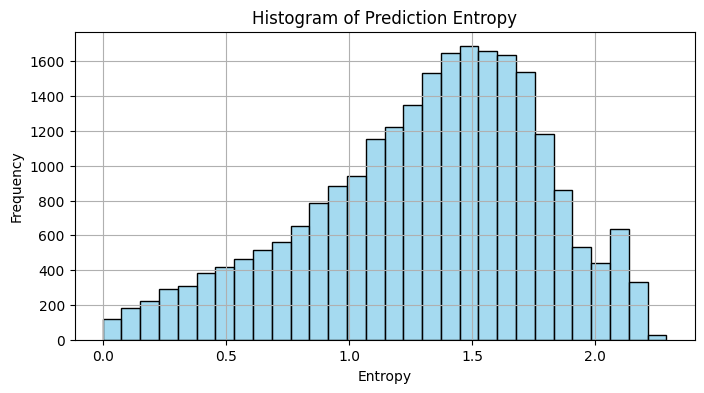

In [70]:

plt.figure(figsize=(8, 4))
sns.histplot(uncertainty_entropy, bins=30, color='skyblue', kde=False)
plt.title('Histogram of Prediction Entropy')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


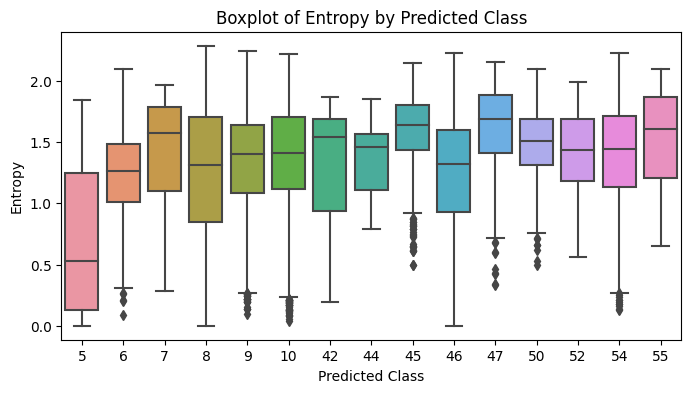

In [69]:
# 创建DataFrame
df = pd.DataFrame({
    'Entropy': uncertainty_entropy,
    'Predicted Class': y_pred  # 假设这是模型的预测类别
})

plt.figure(figsize=(8, 4))
sns.boxplot(x='Predicted Class', y='Entropy', data=df)
plt.title('Boxplot of Entropy by Predicted Class')
plt.xlabel('Predicted Class')
plt.ylabel('Entropy')
plt.show()


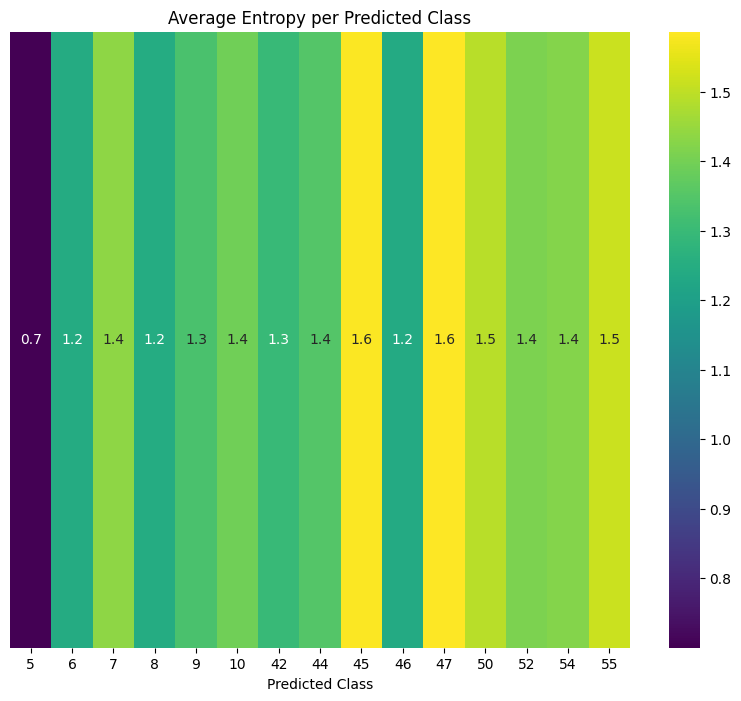

In [61]:
df = pd.DataFrame({
    'Predicted Class': y_pred,
    'Entropy': uncertainty_entropy
})

# 计算每个类别的平均不确定性
class_entropy_avg = df.groupby('Predicted Class')['Entropy'].mean()

plt.figure(figsize=(10, 8))
sns.heatmap(class_entropy_avg.values.reshape(1, -1), annot=True, cmap='viridis', xticklabels=class_entropy_avg.index)
plt.title('Average Entropy per Predicted Class')
plt.yticks([])  # 没有Y轴标签
plt.xlabel('Predicted Class')
plt.show()


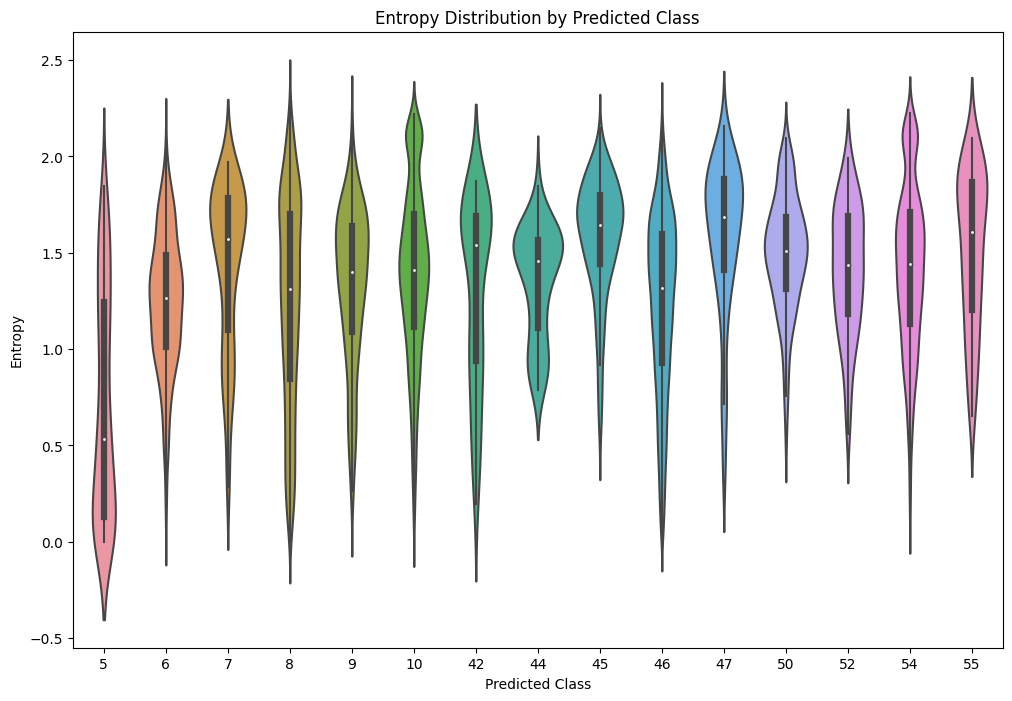

In [63]:
plt.figure(figsize=(12, 8))
sns.violinplot(x='Predicted Class', y='Entropy', data=df)
plt.title('Entropy Distribution by Predicted Class')
plt.xlabel('Predicted Class')
plt.ylabel('Entropy')
plt.show()


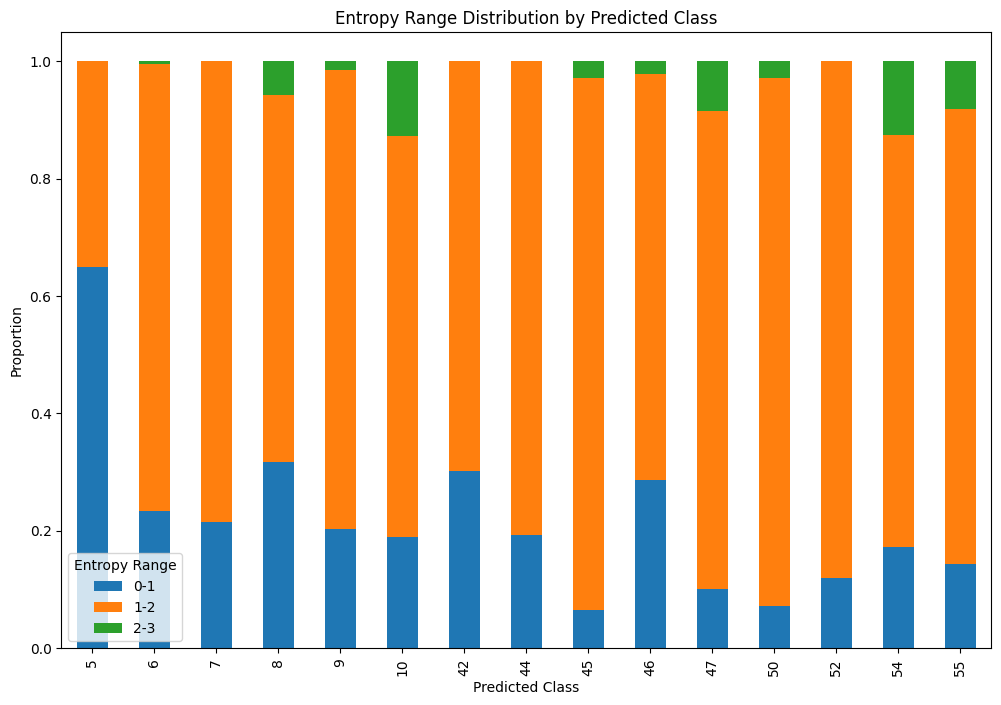

In [64]:
# 定义不确定性区间
bins = [0, 1, 2, 3, 4, np.inf]  # 例如，将熵分为0-1, 1-2, 2-3, 3-4, >4
labels = ['0-1', '1-2', '2-3', '3-4', '>4']
df['Entropy Range'] = pd.cut(df['Entropy'], bins=bins, labels=labels, right=False)

# 计算每个区间的频率
entropy_distribution = pd.crosstab(df['Predicted Class'], df['Entropy Range'], normalize='index')

entropy_distribution.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Entropy Range Distribution by Predicted Class')
plt.xlabel('Predicted Class')
plt.ylabel('Proportion')
plt.legend(title='Entropy Range')
plt.show()
